<h1>Coffe Business</h1>
<h2>By: Wiebke Plückhahn  </h2>
<h2>Date: 06/10/2022</h2>

This case study is intended to be used by a fictitious new company to investigate where suitable locations for the new store would be.
In addition, reviews of other coffee places are to be analyzed for the strategic orientation of the company.
For this analysis, the freely accessible yelp datasets are used (https://www.yelp.com/dataset).

<h2>Analysis of customer reviews for determination of good locations for new cafés</h2>
<h3>Import and data setup </h3>

In [1]:
%pip install pandasql
%pip install textblob
%pip install lxml
%pip install wordcloud
%pip install researchpy
import researchpy as rp
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
import os
import numpy as np
import ast
import matplotlib.pyplot as plt
from pandasql import sqldf
import warnings
import requests
from bs4 import BeautifulSoup
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
import sys
datetime_is_numeric=True
from google.cloud.bigquery import Client, QueryJobConfig
pysqldf = lambda q: sqldf(q, globals())

  Using cached pandasql-0.7.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached regex-2022.10.31-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (757 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached lxml-4.9.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (6.4 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached wordcloud-1.8.2.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (435 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached researchpy-0.3.5-py3-none-any.whl (33 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import of first yelp dataset. Note: this notebook was hosted on the Google Cloud Platform using Google Cloud Storage, BigQuery, and Vertex AI Workbench
client = Client()
query = """SELECT * FROM `coffeeking-370208.yelp.business`"""
job = client.query(query)
dfbusiness = job.to_dataframe()
dfbusiness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150302 entries, 0 to 150301
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   categories    150199 non-null  object 
 1   attributes    136558 non-null  object 
 2   hours         127082 non-null  object 
 3   postal_code   150302 non-null  object 
 4   review_count  150302 non-null  int64  
 5   is_open       150302 non-null  int64  
 6   latitude      150302 non-null  float64
 7   name          150302 non-null  object 
 8   stars         150302 non-null  float64
 9   longitude     150302 non-null  float64
 10  state         150302 non-null  object 
 11  address       150302 non-null  object 
 12  city          150302 non-null  object 
 13  business_id   150302 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [3]:
dfbusinesshours = dfbusiness[['business_id', 'hours']]
dfbusinessattributes = dfbusiness[['business_id', 'attributes']]
dfbusiness.drop(columns=['attributes', 'hours'], inplace=True)

In [4]:
#Keep only businesses that sell coffee
business = pysqldf("SELECT * FROM dfbusiness WHERE categories LIKE '%Coffee%' AND is_open=1;")
business.describe(include='all')

,categories,postal_code,review_count,is_open,latitude,name,stars,longitude,state,address,city,business_id
count,4974,4974,4974.00,4974.00,4974.00,4974,4974.00,4974.00,4974,4974,4974,4974
unique,2889,925,NaN,NaN,NaN,2350,NaN,NaN,14,4888,491,4974
top,"Food, Coffee & Tea",19104,NaN,NaN,NaN,McDonald's,NaN,NaN,PA,,Philadelphia,6WJ-dFE9axF2o55NQWrNgA
freq,362,61,NaN,NaN,NaN,653,NaN,NaN,1227,13,581,1
mean,NaN,NaN,68.39,1.00,37.11,NaN,3.42,-88.37,NaN,NaN,NaN,NaN
std,NaN,NaN,163.10,0.00,6.27,NaN,1.07,14.66,NaN,NaN,NaN,NaN
min,NaN,NaN,5.00,1.00,27.60,NaN,1.00,-120.00,NaN,NaN,NaN,NaN
25%,NaN,NaN,11.00,1.00,32.18,NaN,2.50,-90.27,NaN,NaN,NaN,NaN
50%,NaN,NaN,25.00,1.00,39.54,NaN,3.50,-82.79,NaN,NaN,NaN,NaN
75%,NaN,NaN,60.00,1.00,39.97,NaN,4.50,-75.30,NaN,NaN,NaN,NaN


<AxesSubplot:>

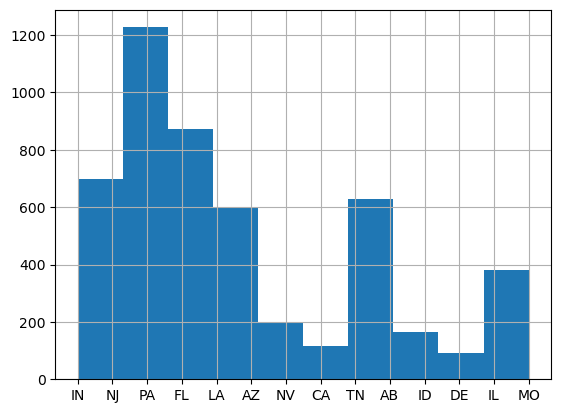

In [5]:
#Examine the frequency of coffee selling business over the US
business['state'].hist()

There seem to be quite many coffee places in **Pennsylvania**, while, for example, the **Illinois** market may not yet be as saturated. However, things need to be put into perspective, therefore the average number of residents (e.g., potential customers) per coffee place will be determined next.

In [6]:
#Import population of each state via webscraping with beautiful soup
wikiurl="https://de.wikipedia.org/wiki/Liste_der_Bundesstaaten_der_Vereinigten_Staaten"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code, "--> 200 means good to go")
soup = BeautifulSoup(response.text, 'html.parser')
state_pop_table=soup.find('table',{'class':"wikitable"})
df_pop=pd.read_html(str(state_pop_table))
# convert list to dataframe
df_pop=pd.DataFrame(df_pop[0])
df_pop.rename(columns={'Einwohner[2](Zensus 2020)':'population', 'Abk.':'state'}, inplace=True)
#in the population table, Alabama is abbreviated as AL, change to AB
df_pop.at[0,'state']='AB'

200 --> 200 means good to go


In [7]:
#Group the business table by state for state-level analyses
states = pysqldf("SELECT state\
                ,COUNT(*) AS total_places \
                 FROM business \
                 GROUP BY state\
                 ;")

In [8]:
#Merge both tables
saturation_states = pd.merge(states, df_pop, how='left', on='state')
#first, make population string an integer
saturation_states['population']=pd.to_numeric(saturation_states['population'].str.replace('.',''))
saturation_states['pop_per_place']=saturation_states.population/saturation_states.total_places
saturation_states.sort_values('pop_per_place', ascending=False)

,state,total_places,Name,Offizieller Spitzname,Hauptstadt,Fläche(km²)[1],RangFläche,population,RangEinw. (2020),Bevölk.-Dichte(Einw./km² 2010),Beitritt,Gouverneur,pop_per_place
2,CA,115,Kalifornien,Golden State,Sacramento,423.967,3,39538223,1,88,9. Sep. 1850,Gavin Newsom (D),343810.63
6,IL,72,Illinois,Land of Lincoln,Springfield,149.995,25,12812508,6,86,3. Dez. 1818,J. B. Pritzker (D),177951.50
1,AZ,268,Arizona,Grand Canyon State,Phoenix,295.234,6,7151502,14,22,14. Feb. 1912,Doug Ducey (R),26684.71
10,NJ,361,New Jersey,Garden State,Trenton,22.591,47,9288994,11,389,18. Dez. 1787,Phil Murphy (D),25731.29
4,FL,873,Florida,Sunshine State,Tallahassee,170.312,22,21538187,3,110,3. März 1845,Ron DeSantis (R),24671.46
7,IN,336,Indiana,Hoosier State,Indianapolis,94.326,38,6785528,17,69,11. Dez. 1816,Eric Holcomb (R),20195.02
9,MO,308,Missouri,Show-Me-State,Jefferson City,180.540,21,6154913,19,33,10. Aug. 1821,Mike Parson (R),19983.48
13,TN,361,Tennessee,Volunteer State,Nashville,109.153,36,6910840,16,58,1. Juni 1796,Bill Lee (R),19143.60
0,AB,268,Alabama,Heart of Dixie,Montgomery,135.767,30,5024279,24,35,14. Dez. 1819,Kay Ivey (R),18747.31
11,NV,197,Nevada,Silver State,Carson City,286.380,7,3104614,32,9,31. Okt. 1864,Steve Sisolak (D),15759.46


<AxesSubplot:xlabel='state'>

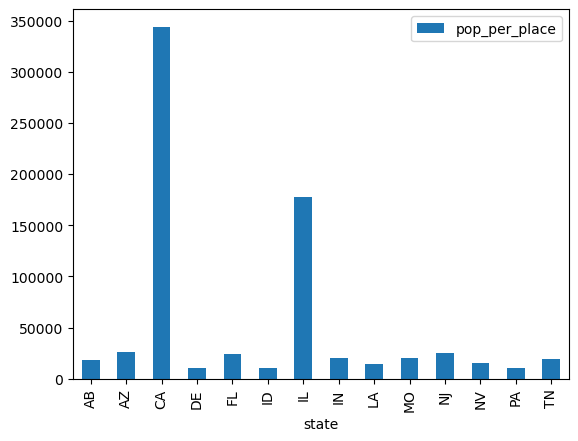

In [9]:
#Plot in a bar chart
saturation_states.plot(x='state', y='pop_per_place', kind='bar')

This confirms, that either **California** or **Illinois** might be good locations for new venues.
Let's dive in a little bit deeper an examine which state really is lacking good coffee.

Average stars of coffee places in California:


<AxesSubplot:>

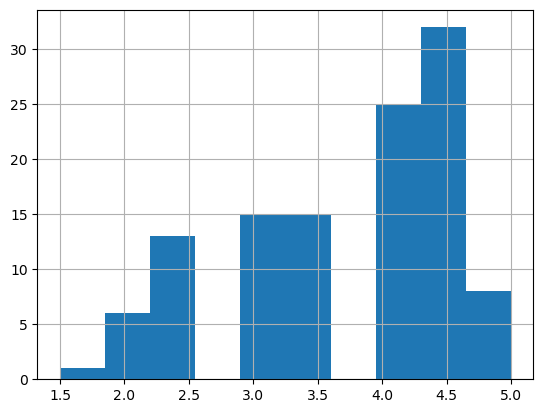

In [10]:
business_ca=business.loc[business['state']=="CA"]
print('Average stars of coffee places in California:')
business_ca['stars'].hist()

Average stars of coffee places in Illinois:


<AxesSubplot:>

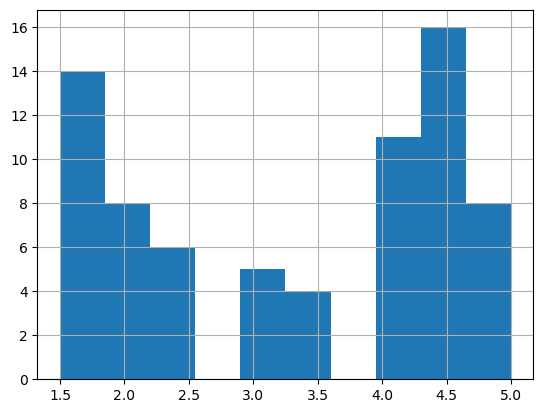

In [11]:
business_il=business.loc[business['state']=="IL"]
print('Average stars of coffee places in Illinois:')
business_il['stars'].hist()

Consequently, opening a café in **Illinois** might be a good idea as Illinois clearly seems to lack good coffee while having relatively many residents per café.
Now let's take a supplementary look at the city level. Here, we only select bigger cities with more than 30 coffee places and businesses with more than 50 reviews as fewer reviews might be prone to be manipulated, which is fatal when analyzing rather small numbers.

In [12]:
df_cities=pysqldf("SELECT \
    city\
    ,state\
    ,avg(stars) AS avg_stars\
    ,AVG(stars*stars) - AVG(stars)*AVG(stars) AS sd_stars\
    ,count(*) AS number_of_cafes\
  FROM dfbusiness \
  WHERE categories LIKE '%Coffee%' AND is_open=1 AND review_count > 50\
  GROUP BY city, state\
  HAVING number_of_cafes > 30\
  ORDER BY avg_stars ASC, sd_stars DESC;")

In [13]:
df_cities

,city,state,avg_stars,sd_stars,number_of_cafes
0,Reno,NV,3.67,1.05,79
1,Tucson,AZ,3.78,0.65,95
2,Nashville,TN,3.88,0.69,93
3,Philadelphia,PA,4.00,0.40,226
4,New Orleans,LA,4.01,0.42,102
5,Tampa,FL,4.04,0.53,97
6,Santa Barbara,CA,4.06,0.34,47
7,Saint Louis,MO,4.09,0.30,41
8,Boise,ID,4.09,0.30,32
9,Saint Petersburg,FL,4.14,0.63,32


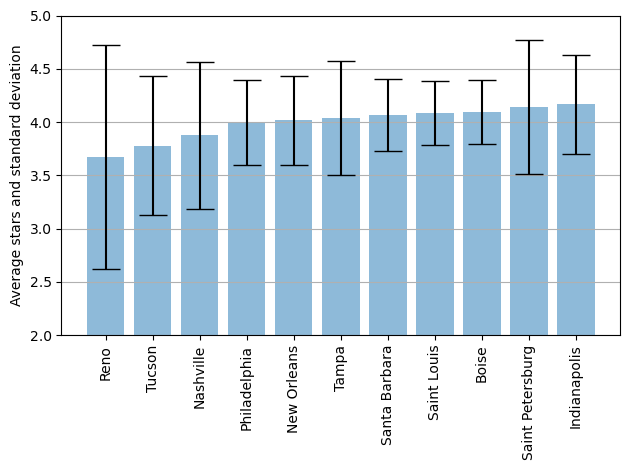

In [14]:
x=df_cities['city'].to_list()
y=df_cities['avg_stars'].to_list()
error=df_cities['sd_stars'].to_list()
x_pos = np.arange(len(x))

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, y, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average stars and standard deviation')
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
plt.xticks(rotation=90, ha='center')
plt.ylim((2,5))
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

Coffee places in Reno seem to be quite unpopular, however, some well rated places exist. **Tucson** seems to be a good hit when scouting on city level, as the average rating of coffee places is comparably low with comparably low standard deviation. A good cafe could hit like a bomb here. Looking back at the state level analysis, **Arizona** performs quite well.

<h3>Review Analysis
</h3>

In [15]:
#Reading in data frame
#The dataframe is a subset of the yelp reviews dataset with only reviews that explicitly address coffee. 
#SQL code:
#SELECT
#  *
#FROM (
#  SELECT
#    business_id AS business
#  FROM
#    `coffeeking-370208.yelp.coffeebusinpsses`)
#LEFT JOIN
#  `coffeeking-370208.yelp.reviews`
#ON
#  business = business_id
#WHERE
#  text LIKE '%offee%'
    
client = Client()
query = """SELECT * FROM `coffeeking-370208.yelp.coffeereviews`"""
job = client.query(query)
dfcoffeereviews = job.to_dataframe()
display(dfcoffeereviews.head(2))
dfcoffeereviews.describe(include='all')

,business,text,cool,funny,stars,date,business_id,user_id,useful,review_id
0,-0gRYq5UjMtZbELj0KHxzA,"great coffee, good pastries. staff is always super friendly. space indoors and outdoors to sit and enjoy your drink/food.",0,0,5.00,2021-07-05 01:37:36+00:00,-0gRYq5UjMtZbELj0KHxzA,rleyEaqrQHqJrpMNH4ru5Q,0,gGQhtc87slpX1jsldQ9V_g
1,-0gRYq5UjMtZbELj0KHxzA,"Good latte on draft. I enjoy the iced tea which they really only have one flavor, black. The sandwiches are good, although they usually run out by the early afternoon. There is no WiFi which seems very bizarre for a coffee shop ? Especially because so many people come to work / study. The seating is also limited and VERY uncomfortable. Overall good place to grab a drink and leave. Not good if your looking for somewhere to stay.",0,0,3.00,2019-06-07 15:45:58+00:00,-0gRYq5UjMtZbELj0KHxzA,z5jIzutUE-t8ftK4rZpq8Q,0,OuJcpzn23tzuwhbsuRH-BA


,business,text,cool,funny,stars,date,business_id,user_id,useful,review_id
count,121546,121546,121546.00,121546.00,121546.00,121546,121546,121546,121546.00,121546
unique,4416,121309,NaN,NaN,NaN,121505,4416,82056,NaN,121546
top,Y2Pfil51rNvTd_lFHwzb_g,"First time, overall experience... Very nice.\nQuaint deco, nice brunch to lunch menu with plenty of options. Certainly not a greasy spoon joint thank goodness.\n\nI enjoyed a veggie egg wrap which was very tasty due to fresh ingredients. My wife enjoyed the cranny chicken on a toasted bun (real chicken pieces with cranrasins. Very nice and lights.\n\nOpen coffee bar, friend servers, in four and out in Langhorne.\n\nWe'll be back as this place out surpasses others we've tried near and in Yardley area.",NaN,NaN,NaN,2014-10-14 20:44:57+00:00,Y2Pfil51rNvTd_lFHwzb_g,-G7Zkl1wIWBBmD0KRy_sCw,NaN,gGQhtc87slpX1jsldQ9V_g
freq,900,3,NaN,NaN,NaN,2,900,91,NaN,1
first,NaN,NaN,NaN,NaN,NaN,2005-04-11 00:42:37+00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2022-01-19 19:31:01+00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.77,0.41,4.09,NaN,NaN,NaN,1.28,NaN
std,NaN,NaN,2.66,1.71,1.24,NaN,NaN,NaN,3.49,NaN
min,NaN,NaN,0.00,0.00,1.00,NaN,NaN,NaN,0.00,NaN
25%,NaN,NaN,0.00,0.00,4.00,NaN,NaN,NaN,0.00,NaN


From the first entries in the dataset in 2007 onwards, a steady positive trend can be seen, with more and more users writing reviews. In 2020, however, this trend is reversed - this could well be due to the pandemic.  When interpreting the following results, it is therefore important to bear in mind that they largely refer to the pre-pandemic coffee culture.

<AxesSubplot:>

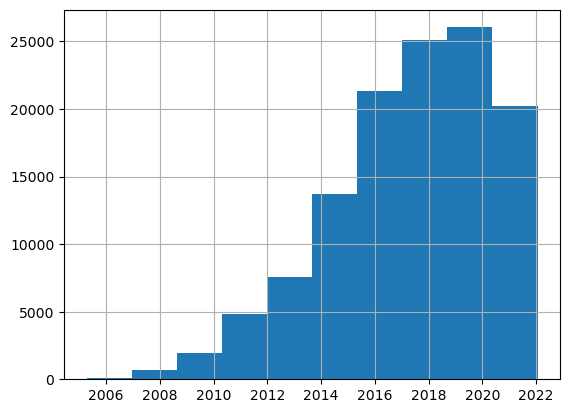

In [16]:
#Exploring publication date of reviews
dfcoffeereviews.date.hist()

<h2> TF-IDF for word frequency </h2>
Next up, reviews will be analyzed for topics that occur very frequent to assess what customers particularly value.
The following list of stopwords should not be included, because they would distort the result in case of word frequency. For example, "and" will probably come up very often.

In [17]:
stopwords =[
"coffee", #as coffee is mentioned in every analyzed review, it's most likely coming up the most
"able",
"about",
"above",
"abroad",
"according",
"accordingly",
"across",
"actually",
"adj",
"after",
"afterwards",
"again",
"against",
"ago",
"ahead",
"ain't",
"all",
"allow",
"allows",
"almost",
"alone",
"along",
"alongside",
"already",
"also",
"although",
"always",
"am",
"amid",
"amidst",
"among",
"amongst",
"an",
"and",
"another",
"any",
"anybody",
"anyhow",
"anyone",
"anything",
"anyway",
"anyways",
"anywhere",
"apart",
"appear",
"appreciate",
"appropriate",
"are",
"aren't",
"around",
"as",
"a's",
"aside",
"ask",
"asking",
"associated",
"at",
"available",
"away",
"awfully",
"back",
"backward",
"backwards",
"be",
"became",
"because",
"become",
"becomes",
"becoming",
"been",
"before",
"beforehand",
"begin",
"behind",
"being",
"believe",
"below",
"beside",
"besides",
"best",
"better",
"between",
"beyond",
"both",
"brief",
"but",
"by",
"came",
"can",
"cannot",
"cant",
"can't",
"caption",
"cause",
"causes",
"certain",
"certainly",
"changes",
"clearly",
"c'mon",
"co",
"co.",
"com",
"come",
"comes",
"concerning",
"consequently",
"consider",
"considering",
"contain",
"containing",
"contains",
"corresponding",
"could",
"couldn't",
"course",
"c's",
"currently",
"dare",
"daren't",
"definitely",
"described",
"despite",
"did",
"didn't",
"different",
"directly",
"do",
"does",
"doesn't",
"doing",
"done",
"don't",
"down",
"downwards",
"during",
"each",
"edu",
"eg",
"eight",
"eighty",
"either",
"else",
"elsewhere",
"end",
"ending",
"enough",
"entirely",
"especially",
"et",
"etc",
"even",
"ever",
"evermore",
"every",
"everybody",
"everyone",
"everything",
"everywhere",
"ex",
"exactly",
"example",
"except",
"fairly",
"far",
"farther",
"few",
"fewer",
"fifth",
"first",
"five",
"followed",
"following",
"follows",
"for",
"forever",
"former",
"formerly",
"forth",
"forward",
"found",
"four",
"from",
"further",
"furthermore",
"get",
"gets",
"getting",
"given",
"gives",
"go",
"goes",
"going",
"gone",
"got",
"gotten",
"greetings",
"had",
"hadn't",
"half",
"happens",
"hardly",
"has",
"hasn't",
"have",
"haven't",
"having",
"he",
"he'd",
"he'll",
"hello",
"help",
"hence",
"her",
"here",
"hereafter",
"hereby",
"herein",
"here's",
"hereupon",
"hers",
"herself",
"he's",
"hi",
"him",
"himself",
"his",
"hither",
"hopefully",
"how",
"howbeit",
"however",
"hundred",
"i'd",
"ie",
"if",
"ignored",
"i'll",
"i'm",
"immediate",
"in",
"inasmuch",
"inc",
"inc.",
"indeed",
"indicate",
"indicated",
"indicates",
"inner",
"inside",
"insofar",
"instead",
"into",
"inward",
"is",
"isn't",
"it",
"it'd",
"it'll",
"its",
"it's",
"itself",
"i've",
"just",
"k",
"keep",
"keeps",
"kept",
"know",
"known",
"knows",
"last",
"lately",
"later",
"latter",
"latterly",
"least",
"less",
"lest",
"let",
"let's",
"like",
"liked",
"likely",
"likewise",
"little",
"look",
"looking",
"looks",
"low",
"lower",
"ltd",
"made",
"mainly",
"make",
"makes",
"many",
"may",
"maybe",
"mayn't",
"me",
"mean",
"meantime",
"meanwhile",
"merely",
"might",
"mightn't",
"mine",
"minus",
"miss",
"more",
"moreover",
"most",
"mostly",
"mr",
"mrs",
"much",
"must",
"mustn't",
"my",
"myself",
"name",
"namely",
"nd",
"near",
"nearly",
"necessary",
"need",
"needn't",
"needs",
"neither",
"never",
"neverf",
"neverless",
"nevertheless",
"new",
"next",
"nine",
"ninety",
"no",
"nobody",
"non",
"none",
"nonetheless",
"noone",
"no-one",
"nor",
"normally",
"not",
"nothing",
"notwithstanding",
"novel",
"now",
"nowhere",
"obviously",
"of",
"off",
"often",
"oh",
"ok",
"okay",
"old",
"on",
"once",
"one",
"ones",
"one's",
"only",
"onto",
"opposite",
"or",
"other",
"others",
"otherwise",
"ought",
"oughtn't",
"our",
"ours",
"ourselves",
"out",
"outside",
"over",
"overall",
"own",
"particular",
"particularly",
"past",
"per",
"perhaps",
"placed",
"please",
"plus",
"possible",
"presumably",
"probably",
"provided",
"provides",
"que",
"quite",
"qv",
"rather",
"rd",
"re",
"really",
"reasonably",
"recent",
"recently",
"recommend",
"regarding",
"regardless",
"regards",
"relatively",
"respectively",
"right",
"round",
"said",
"same",
"saw",
"say",
"saying",
"says",
"second",
"secondly",
"see",
"seeing",
"seem",
"seemed",
"seeming",
"seems",
"seen",
"self",
"selves",
"sensible",
"sent",
"serious",
"seriously",
"seven",
"several",
"shall",
"shan't",
"she",
"she'd",
"she'll",
"she's",
"should",
"shouldn't",
"since",
"six",
"so",
"some",
"somebody",
"someday",
"somehow",
"someone",
"something",
"sometime",
"sometimes",
"somewhat",
"somewhere",
"soon",
"sorry",
"specified",
"specify",
"specifying",
"still",
"sub",
"such",
"sup",
"sure",
"take",
"taken",
"taking",
"tell",
"tends",
"th",
"than",
"thank",
"thanks",
"thanx",
"that",
"that'll",
"thats",
"that's",
"that've",
"the",
"their",
"theirs",
"them",
"themselves",
"then",
"thence",
"there",
"thereafter",
"thereby",
"there'd",
"therefore",
"therein",
"there'll",
"there're",
"theres",
"there's",
"thereupon",
"there've",
"these",
"they",
"they'd",
"they'll",
"they're",
"they've",
"thing",
"things",
"think",
"third",
"thirty",
"this",
"thorough",
"thoroughly",
"those",
"though",
"three",
"through",
"throughout",
"thru",
"thus",
"till",
"to",
"together",
"too",
"took",
"toward",
"towards",
"tried",
"tries",
"truly",
"try",
"trying",
"t's",
"twice",
"two",
"un",
"under",
"underneath",
"undoing",
"unfortunately",
"unless",
"unlike",
"unlikely",
"until",
"unto",
"up",
"upon",
"upwards",
"us",
"use",
"used",
"useful",
"uses",
"using",
"usually",
"v",
"value",
"various",
"versus",
"very",
"via",
"viz",
"vs",
"want",
"wants",
"was",
"wasn't",
"way",
"we",
"we'd",
"welcome",
"well",
"we'll",
"went",
"were",
"we're",
"weren't",
"we've",
"what",
"whatever",
"what'll",
"what's",
"what've",
"when",
"whence",
"whenever",
"where",
"whereafter",
"whereas",
"whereby",
"wherein",
"where's",
"whereupon",
"wherever",
"whether",
"which",
"whichever",
"while",
"whilst",
"whither",
"who",
"who'd",
"whoever",
"whole",
"who'll",
"whom",
"whomever",
"who's",
"whose",
"why",
"will",
"willing",
"wish",
"with",
"within",
"without",
"wonder",
"won't",
"would",
"wouldn't",
"yes",
"yet",
"you",
"you'd",
"you'll",
"your",
"you're",
"yours",
"yourself",
"yourselves",
"you've",
"zero",
"a",
"how's",
"i",
"when's",
"why's",
"b",
"c",
"d",
"e",
"f",
"g",
"h",
"j",
"l",
"m",
"n",
"o",
"p",
"q",
"r",
"s",
"t",
"u",
"uucp",
"w",
"x",
"y",
"z",
"I",
"amazing",
"great",
"good",
"coffee.",
"nice",
"ordered",
"coffee,",
"place.",
"sweet",
"order",
"people",
"cup",
"it.",
"work",
"super",
"favorite",
"cafe",
"good.",
"bit",
"day",
"lot",
"worst",
"terrible",
"terrible.",
"10", 
"coffees",
"told",
"again.",
"order.",
"dunkin",
"love",
"too!",
"excellent.",
"had.",
"horrible",
"bad",
"asked",
"20",
"2",
"5",
"3",
"\n\nthe",
"wanted",
"here.",
"customer",
"bad.",
"drive",
"horrible.",
"excellent",
"awesome",
"perfect",
"wonderful",
"coffee!",
"loved",
"too.",
"great.",
"money",
"awful",
"ever.",
"too!",
"excellent.",
"had.",
"www",
"amount",
"bill",
"bottom",
"call",
"computer",
"con",
"couldnt",
"cry",
"de",
"describe",
"detail",
"due",
"eleven",
"empty",
"fifteen",
"fifty",
"fill",
"find",
"fire",
"forty",
"front",
"full",
"give",
"hasnt",
"herse",
"himse",
"interest",
"itse”",
"mill",
"move",
"myse”",
"part",
"put",
"show",
"side",
"sincere",
"sixty",
"system",
"ten",
"thick",
"thin",
"top",
"twelve",
"twenty",
"abst",
"accordance",
"act",
"added",
"adopted",
"affected",
"affecting",
"affects",
"ah",
"announce",
"anymore",
"apparently",
"approximately",
"aren",
"arent",
"arise",
"auth",
"beginning",
"beginnings",
"begins",
"biol",
"briefly",
"ca",
"date",
"ed",
"effect",
"et-al",
"ff",
"fix",
"gave",
"giving",
"heres",
"hes",
"hid",
"home",
"id",
"im",
"immediately",
"importance",
"important",
"index",
"information",
"invention",
"itd",
"keys",
"kg",
"km",
"largely",
"lets",
"line",
"'ll",
"means",
"mg",
"million",
"ml",
"mug",
"na",
"nay",
"necessarily",
"nos",
"noted",
"obtain",
"obtained",
"omitted",
"ord",
"owing",
"page",
"pages",
"place",
"poorly",
"possibly",
"potentially",
"pp",
"predominantly",
"present",
"previously",
"primarily",
"promptly",
"proud",
"quickly",
"ran",
"readily",
"ref",
"refs",
"related",
"research",
"resulted",
"resulting",
"results",
"run",
"sec",
"section",
"shed",
"shes",
"showed",
"shown",
"showns",
"shows",
"significant",
"significantly",
"similar",
"similarly",
"slightly",
"somethan",
"specifically",
"state",
"states",
"stop",
"strongly",
"substantially",
"successfully",
"sufficiently",
"suggest",
"thered",
"thereof",
"therere",
"thereto",
"theyd",
"theyre",
"thou",
"thoughh",
"thousand",
"throug",
"til",
"tip",
"ts",
"ups",
"usefully",
"usefulness",
"'ve",
"vol",
"vols",
"wed",
"whats",
"wheres",
"whim",
"whod",
"whos",
"widely",
"words",
"world",
"youd",
"youre",
"",
"&",
",",
".",
"-"]

sw_df = pd.DataFrame(stopwords, columns=['stopwords'])

Now, a word frequency analysis is performed using Counter. The top 30 most frequently mentioned words will be provided for further visualization.

In [18]:
no_sw = dfcoffeereviews.text.apply(lambda word: [word.lower() for word in word.split(' ') if word.lower() not in stopwords])
                                  
corpus=[]
for ea in no_sw:
    corpus += ea
wordDict = Counter(corpus)
frequentwords=[ (k, v) for k, v in sorted(wordDict.items(), key = lambda item: item[1], reverse=True)][:30]
frequentwords

[('food', 27667),
 ('time', 23885),
 ('breakfast', 20556),
 ('shop', 19304),
 ('staff', 19225),
 ('service', 18666),
 ('friendly', 18241),
 ('iced', 14831),
 ('pretty', 13279),
 ('delicious', 12550),
 ('drink', 12524),
 ('latte', 11917),
 ('location', 10921),
 ('small', 10580),
 ('hot', 10204),
 ('local', 10200),
 ('wait', 10173),
 ('menu', 10156),
 ('spot', 9955),
 ('drinks', 9797),
 ('fresh', 9587),
 ('seating', 9480),
 ('starbucks', 9353),
 ('tea', 9144),
 ('morning', 8320),
 ('cream', 8287),
 ('chocolate', 8168),
 ('area', 7784),
 ('sandwich', 7779),
 ('cold', 7767)]

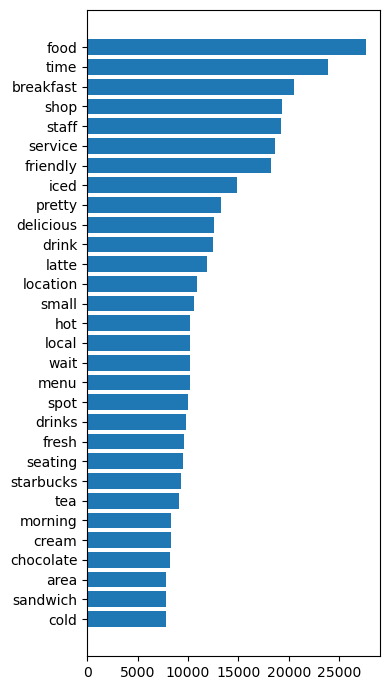

In [19]:
df_frequentwords=pd.DataFrame(frequentwords, columns=['word', 'frequency'])

fig, ax = plt.subplots()
fig.set_size_inches(4, 7)
ax.barh(df_frequentwords['word'], df_frequentwords['frequency'])
ax.invert_yaxis()
fig.tight_layout()
plt.show()

Looking at the bar chart, the company should also consider offering food. Furthermore, especially in the selection of service staff it should pay attention to choose friendly and quick-working people, as these aspects were often mentioned in the reviews. The location of the cafe should be carefully selected and lovingly designed with some seating. Especially in the morning there seem to be many customers who write reviews, so a little more service staff should be scheduled at this time of day.
The following word cloud also presents these findings and also provides some suggestions for food options that are often highlighted in reviews.

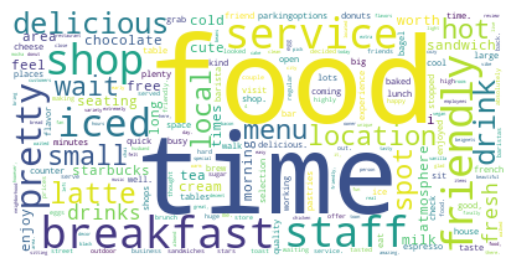

In [20]:
wordcloud = WordCloud(background_color='white', min_word_length=1, prefer_horizontal=0.9).generate_from_frequencies(wordDict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2> Sentiment Analysis</h2>
Next, a sentiment analysis is to be performed. TextBlob provides automated NLP and computes a sentiment score from -1 (very negative) to +1 (very positive) for each review.

<AxesSubplot:>

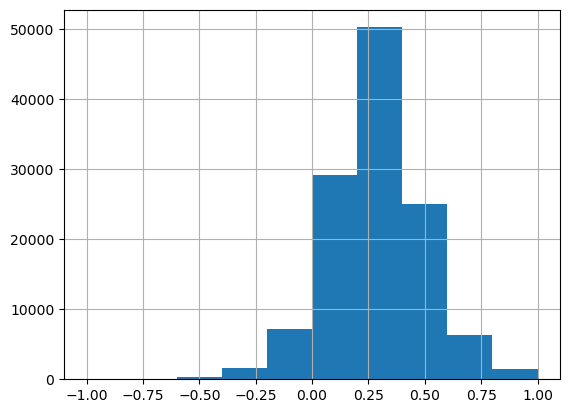

In [21]:
dfcoffeereviews['sentiment'] = dfcoffeereviews.text.apply(lambda text: TextBlob(text).sentiment[0])
dfcoffeereviews['sentiment'].describe()
dfcoffeereviews.sentiment.hist()

Generally speaking, reviews are quite benevolent and positive. But what is it what upsets people at other coffee places? And what do they find particularly positive?
To answer these questions, two supplementary text frequency analyses are to be performed that list topics from very positive vs. very negative reviews.
As the distribution of sentiment is very right-leaning, a cut-off of 0.75 for very positive reviews is used. Very negative reviews are considered all with a sentiment < -.5. This also is reasonable, as potential customers are more likely to be put off by negative reviews than attracted by positive ones.

In [22]:
dfpositivereviews = dfcoffeereviews.loc[dfcoffeereviews['sentiment'] > .75]
display(dfpositivereviews.describe())
dfnegativereviews = dfcoffeereviews.loc[dfcoffeereviews['sentiment'] < -.5]
dfnegativereviews.describe()

,cool,funny,stars,useful,sentiment
count,2114.00,2114.00,2114.00,2114.00,2114.00
mean,0.23,0.10,4.82,0.39,0.86
std,0.77,0.86,0.51,0.98,0.08
min,0.00,0.00,1.00,0.00,0.75
25%,0.00,0.00,5.00,0.00,0.79
50%,0.00,0.00,5.00,0.00,0.83
75%,0.00,0.00,5.00,0.00,0.91
max,13.00,34.00,5.00,14.00,1.00


,cool,funny,stars,useful,sentiment
count,265.00,265.00,265.00,265.00,265.00
mean,0.18,0.34,1.32,0.98,-0.68
std,0.90,1.10,0.80,4.86,0.15
min,0.00,0.00,1.00,0.00,-1.00
25%,0.00,0.00,1.00,0.00,-0.75
50%,0.00,0.00,1.00,0.00,-0.62
75%,0.00,0.00,1.00,1.00,-0.56
max,11.00,13.00,5.00,57.00,-0.50


As expected, negative reviews score quite low on stars while very positive reviews score very high. This is a good indication for a well-performing sentiment analysis. Also, it's interesting to see that negative reviews are rated more useful by other users than positive reviews. Next, this is statistically tested to provide recommendations about the valence that most importantly should be considered.

In [23]:
summary, results = rp.ttest(group1= dfpositivereviews['useful'], group1_name= "positive",
                            group2= dfnegativereviews['useful'], group2_name= "negative")
results.iloc[0:4]

,Independent t-test,results
0,Difference (positive - negative) =,-0.58
1,Degrees of freedom =,2377.00
2,t =,-4.79
3,Two side test p value =,0.00


The difference is highly significant, meaning that other users/potential customers value negative reviews significantly more than positive reviews. Hence, especially topics criticized in negative reviews should be avoided. These issues will now be determined.

In [24]:
no_neg_sw = dfnegativereviews.text.apply(lambda word: [word.lower() for word in word.split(' ') if word.lower() not in stopwords])
                                  
corpus=[]
for ea in no_neg_sw:
    corpus += ea
negwordDict = Counter(corpus)
frequentnegativewords=[ (k, v) for k, v in sorted(negwordDict.items(), key = lambda item: item[1], reverse=True)][:30]
frequentnegativewords

[('service', 35),
 ('food', 32),
 ('starbucks', 31),
 ('iced', 28),
 ('minutes', 27),
 ('cold', 24),
 ('rude', 23),
 ('drink', 23),
 ('tasted', 22),
 ('experience', 20),
 ('taste', 18),
 ('location', 17),
 ('staff', 16),
 ('waited', 16),
 ('wait', 15),
 ('time', 15),
 ('donuts', 15),
 ('service.', 15),
 ('ice', 13),
 ('milk', 13),
 ('service,', 12),
 ('waiting', 11),
 ('wrong', 11),
 ('latte', 11),
 ('times', 11),
 ('tastes', 10),
 ('dirty', 10),
 ('disgusting.', 10),
 ('min', 10),
 ('manager', 9)]

In [25]:
no_pos_sw = dfpositivereviews.text.apply(lambda word: [word.lower() for word in word.split(' ') if word.lower() not in stopwords])
                                  
corpus=[]
for ea in no_pos_sw:
    corpus += ea
poswordDict = Counter(corpus)
frequentpositivewords=[ (k, v) for k, v in sorted(poswordDict.items(), key = lambda item: item[1], reverse=True)][:30]
frequentpositivewords

[('delicious', 305),
 ('breakfast', 261),
 ('food', 219),
 ('service', 217),
 ('staff', 148),
 ('shop', 136),
 ('delicious.', 130),
 ('iced', 123),
 ('latte', 111),
 ('atmosphere', 100),
 ('friendly', 98),
 ('spot', 84),
 ('pastries', 77),
 ('ice', 77),
 ('service.', 69),
 ('beautiful', 67),
 ('place!', 65),
 ('sandwich', 59),
 ('service,', 59),
 ('delicious!', 59),
 ('morning', 58),
 ('tea', 57),
 ('cheese', 56),
 ('lunch', 55),
 ('cream', 54),
 ('selection', 53),
 ('drink', 52),
 ('service!', 51),
 ('milk', 50),
 ('drinks', 50)]

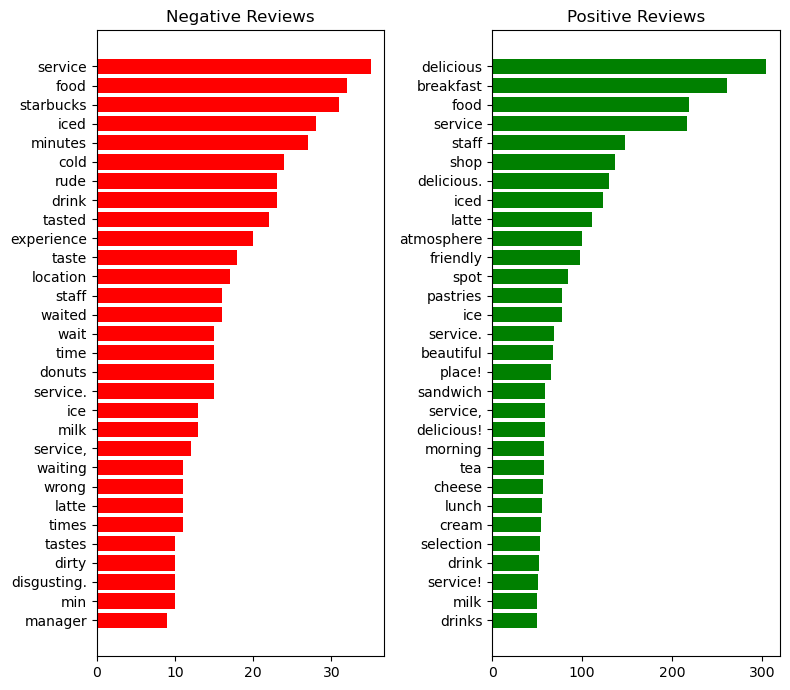

In [26]:
df_frequentpositivewords=pd.DataFrame(frequentpositivewords, columns=['word', 'frequency'])
df_frequentnegativewords=pd.DataFrame(frequentnegativewords, columns=['word', 'frequency'])

fig=plt.figure()
fig.set_size_inches(8, 7)
ax=fig.add_subplot(121)
ax.set(title="Negative Reviews")
ax.barh(df_frequentnegativewords['word'], df_frequentnegativewords['frequency'], color='red')
ax.invert_yaxis()
ax=fig.add_subplot(122)
ax.set(title="Positive Reviews")
ax.barh(df_frequentpositivewords['word'], df_frequentpositivewords['frequency'], color='green')
ax.invert_yaxis()
fig.tight_layout()
plt.show()

Looking at these graphics the young business clearly should focus on great service. Also, when selling food paying attention to great flavour is recommended. Milk is a topic in both positive and negative reviews, the coffee shop should consider offering different alternatives, like soy or oat milk. In the negative reviews the waiting times are referrenced a lot, so the company should prevent long queues. Another priority should definitely be the hygiene.
The word clouds below further visualize most frequent words in positive and negative reviews.

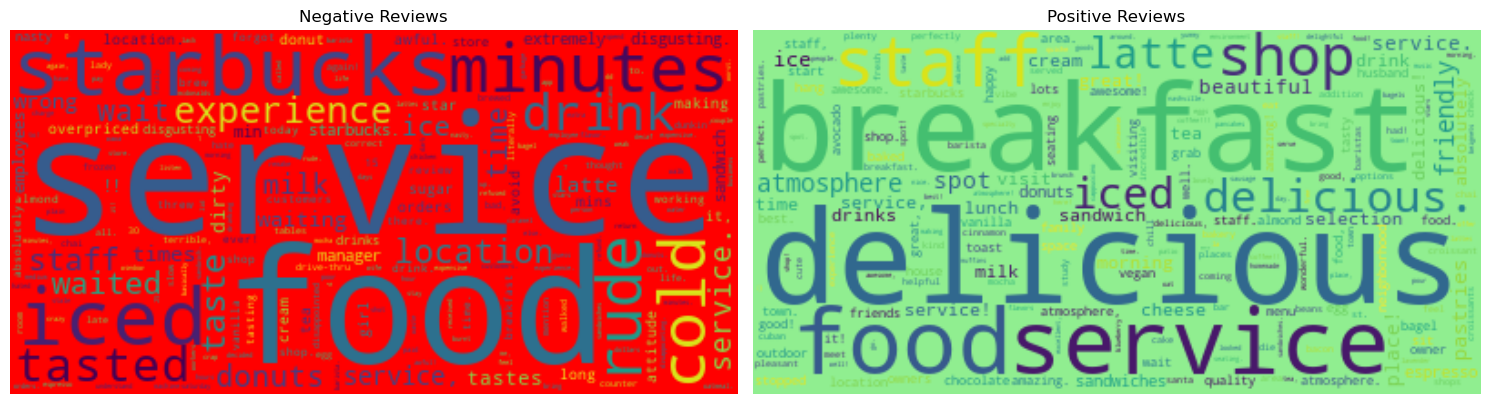

In [27]:
negwordcloud = WordCloud(background_color='red', min_word_length=1, prefer_horizontal=0.8).generate_from_frequencies(negwordDict)
poswordcloud = WordCloud(background_color='lightgreen', min_word_length=1, prefer_horizontal=0.8).generate_from_frequencies(poswordDict)

fig=plt.figure()
fig.set_size_inches(15, 8)
ax=fig.add_subplot(121)
ax.set(title="Negative Reviews")
ax.imshow(negwordcloud, interpolation='bilinear')
ax.axis("off")
ax=fig.add_subplot(122)
ax.set(title="Positive Reviews")
ax.imshow(poswordcloud, interpolation='bilinear')
ax.axis("off")
fig.tight_layout()
plt.show()